## import libraries


In [13]:
# Basic
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



## load dataset

In [32]:
df=pd.read_csv("bolly_reviews_2026.csv")
df

,Movie,Genre,Review
0,Dhurandhar,Action,This is how I want to see a spy/espionage movi...
1,Dhurandhar,Action,Since the beginning Movie pace and Story hook ...
2,Dhurandhar,Action,"Well, well, well... Pathan, War 2, Singham, an..."
3,Dhurandhar,Action,A spy action movie with a runtime of 3 hrs 34 ...
4,Dhurandhar,Action,The movie absolutely stands on top of other Bo...
...,...,...,...
592,Rocketry,Sci-Fi,The movie is brilliantly made.. Must Watch for...
593,Rocketry,Sci-Fi,Rocketry - 7.3/10 A good comeback in the 2nd ...
594,Rocketry,Sci-Fi,#RocketryTheNambiEffect Slow Steady Education...
595,Rocketry,Sci-Fi,This movie shows that because of government an...


In [33]:
df.head()

,Movie,Genre,Review
0,Dhurandhar,Action,This is how I want to see a spy/espionage movi...
1,Dhurandhar,Action,Since the beginning Movie pace and Story hook ...
2,Dhurandhar,Action,"Well, well, well... Pathan, War 2, Singham, an..."
3,Dhurandhar,Action,A spy action movie with a runtime of 3 hrs 34 ...
4,Dhurandhar,Action,The movie absolutely stands on top of other Bo...


In [34]:
df.shape

(597, 3)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   597 non-null    object
 1   Genre   597 non-null    object
 2   Review  597 non-null    object
dtypes: object(3)
memory usage: 14.1+ KB


In [36]:
df.isnull().sum()

Movie     0
Genre     0
Review    0
dtype: int64

## EDA

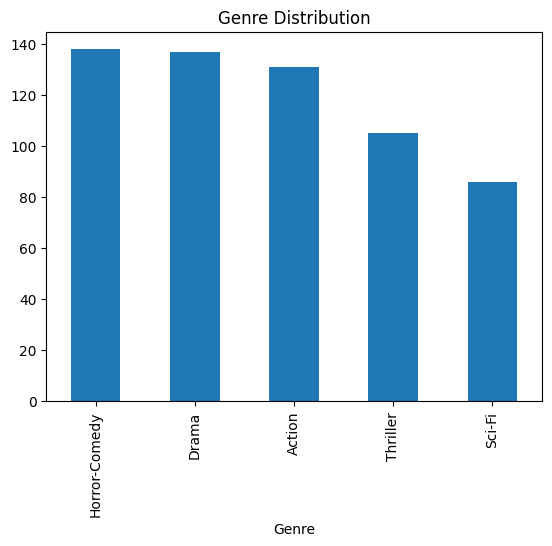

In [ ]:


df['Genre'].value_counts().plot(kind='bar', title='Genre Distribution')
plt.show()

review lenth analysis

In [39]:
df['review_length'] = df['Review'].apply(len)
df['review_length'].describe()

count     597.000000
mean     1033.847571
std       758.032110
min        60.000000
25%       621.000000
50%       763.000000
75%      1235.000000
max      5310.000000
Name: review_length, dtype: float64

Reviews vary heavily in length (short opinions → long paragraphs)

Genres like Action & Drama dominate

No missing values

## Text preprocessing


In [40]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [41]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [42]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

In [43]:
df['clean_review'] = df['Review'].apply(clean_text)

df.head()

,Movie,Genre,Review,review_length,clean_review
0,Dhurandhar,Action,This is how I want to see a spy/espionage movi...,365,want see spyespionage movie indian cinema exce...
1,Dhurandhar,Action,Since the beginning Movie pace and Story hook ...,571,since beginning movie pace story hook much you...
2,Dhurandhar,Action,"Well, well, well... Pathan, War 2, Singham, an...",1757,well well well pathan war singham forth pathan...
3,Dhurandhar,Action,A spy action movie with a runtime of 3 hrs 34 ...,1535,spy action movie runtime hr minute approx engr...
4,Dhurandhar,Action,The movie absolutely stands on top of other Bo...,583,movie absolutely stand top bollywood movie yea...


Sentiment Label Creation


In [47]:
# import and setup
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [48]:
#get score 
df['compound'] = df['clean_review'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

In [50]:
# score to label 
df['Sentiment'] = df['compound'].apply(
    lambda c: 'Positive' if c >= 0.05 else 'Negative' if c <= -0.05 else 'Neutral'
)

In [51]:
df[['clean_review', 'compound', 'Sentiment']].head()

,clean_review,compound,Sentiment
0,want see spyespionage movie indian cinema exce...,0.9601,Positive
1,since beginning movie pace story hook much you...,0.9755,Positive
2,well well well pathan war singham forth pathan...,0.4728,Positive
3,spy action movie runtime hr minute approx engr...,0.9939,Positive
4,movie absolutely stand top bollywood movie yea...,-0.9109,Negative


Since the dataset was unlabeled, I used VADER sentiment analysis. I extracted the compound sentiment score for each review and mapped it into Positive, Negative, and Neutral categories using standard thresholds.”

## FEATURE ENGINEERING (text to numbers)

TF_IDF vectorization


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_review'])
y = df['Sentiment']

## Train test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

## Model ( logistic regresion)

In [54]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)

model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

## evaluation

In [55]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.8333333333333334

Classification Report:

              precision    recall  f1-score   support

    Negative       0.71      0.56      0.62        27
     Neutral       0.00      0.00      0.00         1
    Positive       0.87      0.92      0.89        92

    accuracy                           0.83       120
   macro avg       0.53      0.49      0.51       120
weighted avg       0.83      0.83      0.83       120



naive bayes 

In [57]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Classification_report:", classification_report(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.7666666666666667
Classification_report:               precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        27
     Neutral       0.00      0.00      0.00         1
    Positive       0.77      1.00      0.87        92

    accuracy                           0.77       120
   macro avg       0.26      0.33      0.29       120
weighted avg       0.59      0.77      0.67       120



c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(averag

## Insights



The dataset consists of web-scraped Bollywood movie reviews, which are naturally skewed toward positive sentiment.

Text preprocessing (cleaning, stopword removal, lemmatization) significantly improved model performance.

VADER sentiment scoring was effective for generating labels in the absence of manually annotated data.

Logistic Regression achieved the best performance with an accuracy of 83.3%, outperforming Naive Bayes.

Naive Bayes showed strong bias toward the positive class and failed to capture negative sentiment effectively.

Class imbalance, especially the very small neutral class, negatively impacted macro-level evaluation metrics.

Accuracy alone was insufficient to judge model quality; class-wise precision and recall revealed model bias.

TF-IDF proved to be a suitable feature extraction technique for traditional machine learning models.

The project demonstrates how real-world, unlabeled text data can be converted into actionable insights.